Valid time =  407.0


C:\Users\gouhe\anaconda3\lib\site-packages\ipykernel_launcher.py:159: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


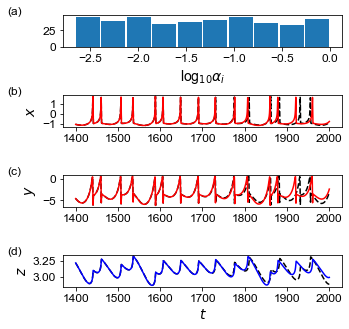

In [6]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

#################################################################
# pred_HR_longterm.py: longterm prediction of Hindmarsh-Rose model
# (c) 2022 Gouhei Tanaka
# Citation:
# Tanaka et al., "Reservoir computing with diverse timescales for 
# prediction of multiscale dynamics", Phys. Rev. Res., L032014, 2022.
#################################################################

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from esn_dts_closedloop import ESN, Tikhonov


np.random.seed(seed=0)

def eval_validtime_1D(Y, Y_pred, thres=0.4, dt=0.05):
    pred_len = len(Y_pred)
    valid_time = pred_len*dt

    mean_norm = np.abs(np.mean(Y))
    #print(mean_norm)
    
    for i in range(pred_len):
        y = Y[i].flatten()
        y_pred = Y_pred[i].flatten()
        error = np.linalg.norm(y - y_pred, ord=2)/mean_norm
        
        if error >= thres:
            valid_time = i *dt
            break

    return valid_time


# function that returns dv/dt
def model(v,t,b,I,eps,s,x0):
    dxdt = v[1] - v[0]**3 + b*v[0]**2 - v[2] + I
    dydt = 1 - 5.0*v[0]**2 - v[1]
    dzdt = eps*(s*(v[0]-x0)-v[2])
    dvdt = [dxdt,dydt,dzdt]
    return dvdt


# data generation
def gen_HR(T):
           
    # initial condition
    v0 = np.random.rand(3)
    
    # time points
    dt = 0.05
    t_len = T*dt
    t = np.linspace(0, t_len, T)

    # parameters
    b = 3.05
    I = 3.1
    eps = 0.01
    s = 4.0
    x0 = -1.6
    
    # solve ODE
    v = odeint(model,v0,t,args=(b,I,eps,s,x0))
    return v


# setting input and output data
def set_data(T0):
    v = gen_HR(T0)
    u0 = np.vstack((v[:,0], v[:,1], v[:,2]))
    d0 = np.vstack((v[:,0], v[:,1], v[:,2]))
    
    # if 1-dim, convert to 2-dim
    if u0.ndim == 1:
        u0 = u0.reshape(1, -1)
    if d0.ndim == 1:
        d0 = d0.reshape(1, -1)
        
    return u0, d0


if __name__ == '__main__':

    # time setting
    dt = 0.05
    tau = 1
    T0 = 2000*int(1/dt)+tau
    T_trans = 200*int(1/dt)
    T = T0-tau-T_trans
    
    # data choice
    u0, d0 = set_data(T0)

    # data setting
    u = u0[:, T_trans:T_trans+T]
    d = d0[:, T_trans+tau:T_trans+tau+T]
    T_test = 600*int(1/dt)
    T_train = T - T_test
    
    # data for training and testing
    train_U = u[:, :T_train].T
    train_D = d[:, :T_train].T
    test_U = u[:, T_train:].T
    test_D = d[:, T_train:].T
    
    # parameter values
    N_x = 400
    density = 0.1
    input_scale = 0.6
    rho = 0.2
    fb_scale = 0.4
    beta = 1e-3
    
    # leak_rate (default: scale_max=scale_min=0)
    scale_max = 0
    scale_min = -24/9
    power = scale_min + (scale_max-scale_min)*np.random.rand(N_x)
    base = np.ones(N_x)*10.0
    leaking_rate = [a ** b for (a, b) in zip(base, power)]
    leaking_rate.sort()
    #np.savetxt('leaking_rate.txt', leaking_rate)
    #print(leaking_rate)
        
    # ESN
    list_trial = [4]  # seed of random number
    for trial in list_trial:
        model = ESN(train_U.shape[1], train_D.shape[1], N_x, 
                    density=density, input_scale=input_scale, rho=rho,
                    fb_scale=fb_scale, fb_seed=trial, 
                    leaking_rate=np.array(leaking_rate), seed=trial)

        # ridge regression
        train_Y = model.train(train_U, train_D, Tikhonov(N_x, train_D.shape[1], beta=beta)) 

        # prediction
        run_Y = model.run(test_U)
        
        # evaluation (validtime)
        VT = eval_validtime_1D(test_D[:,2].T, run_Y[:,2].T, thres=0.05, dt=dt)
        print('Valid time = ',VT)
        

    # data for figures
    T_range = (T0-T_test, T0)
    disp_t = np.arange(T_range[0], T_range[1])
    disp_t = disp_t*dt
    disp_U = np.concatenate((train_U[T_range[0]:], test_U[:T_range[1]]))
    disp_D = np.concatenate((train_D[T_range[0]:], test_D[:T_range[1]]))
    disp_Y = np.concatenate((train_Y[T_range[0]:], run_Y[:T_range[1]]))
    
    # draw
    plt.rcParams['font.size'] = 12
    plt.rcParams['font.family'] = 'Arial'
    fig, ax = plt.subplots(4, 1, figsize=(5,5), constrained_layout=True)
    plt.subplots_adjust(hspace=1.5)
    
    # alpha histogram
    ax[0].text(-0.2, 1, '(a)', transform=ax[0].transAxes)
    ax[0].hist(power, rwidth=0.95)
    ax[0].set_xlabel(r'log$_{10}\alpha_i$', fontsize=14)
    
    # prediction results
    marks = ['(b)', '(c)', '(d)']
    colors = ['red', 'red', 'blue']
    ylabels = ['$x$', '$y$', '$z$']
    for i in range(3):
        ax[i+1].text(-0.2, 1, marks[i], transform=ax[i+1].transAxes)
        ax[i+1].plot(disp_t, disp_D[:,i], color='k', linestyle='--', label='Target')
        ax[i+1].plot(disp_t, disp_Y[:,i], color=colors[i], label='Model')
        ax[i+1].set_ylabel(ylabels[i], fontsize=14)
        #ax[i+1].legend(bbox_to_anchor=(1, 1), loc='upper right')
    ax[i+1].set_xlabel('$t$', fontsize=14)
    
    plt.show()
